1. Baseline, eyes open
2. Baseline, eyes closed
3. Task 1 (open and close left or right fist)
4. Task 2 (imagine opening and closing left or right fist)
5. Task 3 (open and close both fists or both feet)
6. Task 4 (imagine opening and closing both fists or both feet)
7. Task 1
8. Task 2
9. Task 3
10. Task 4
11. Task 1
12. Task 2
13. Task 3
14. Task 4

### 讀取

In [23]:
import numpy as np
from scipy.signal import welch

def extract_frequency_features(segment, fs=200, freq_bands=[(1,4), (4,8), (8,12), (12,30)]):
    # segment: shape (channels, segment_length)
    # fs: 取樣頻率 (需根據你的資料實際取樣率設定)
    # freq_bands: 要計算能量的頻帶列表
    # 回傳此 segment 的頻域特徵 (channels, len(freq_bands))

    # 使用 welch 計算每個 channel 的 PSD
    # nperseg可自行調整，通常為 segment_length，不過需注意奇偶
    f, psd = welch(segment, fs=fs, nperseg=segment.shape[1], axis=1)

    # psd shape: (channels, freq_bins)
    # 接著計算各頻帶功率
    freq_features = []
    for ch in range(psd.shape[0]):
        ch_psd = psd[ch]
        band_powers = []
        for (low_f, high_f) in freq_bands:
            # 找到對應的頻率區間索引
            idx = np.logical_and(f >= low_f, f <= high_f)
            # 計算該頻帶能量 (可用 sum 或平均)
            band_power = np.sum(ch_psd[idx])
            band_powers.append(band_power)
        freq_features.append(band_powers)
    freq_features = np.array(freq_features)  # (channels, len(freq_bands))
    freq_features = freq_features.flatten()  # 攤平

    return freq_features


In [24]:
def extract_fft_features(segment, fs=200, freq_bands=[(1,4), (4,8), (8,12), (12,30)]):
    # 將 time domain 信號對每個 channel 做 FFT
    fft_vals = np.fft.rfft(segment, axis=1)  # (channels, freq_bins)
    freqs = np.fft.rfftfreq(segment.shape[1], d=1/fs)
    
    # 計算能量譜
    psd = np.abs(fft_vals)**2
    
    freq_features = []
    for ch in range(psd.shape[0]):
        ch_psd = psd[ch]
        band_powers = []
        for (low_f, high_f) in freq_bands:
            idx = np.logical_and(freqs >= low_f, freqs <= high_f)
            band_power = np.sum(ch_psd[idx])
            band_powers.append(band_power)
        freq_features.append(band_powers)
    freq_features = np.array(freq_features).flatten()
    return freq_features


In [25]:
from scipy.stats import skew, kurtosis

def extract_time_features(segment):
    # segment: (channels, segment_length)
    # 計算各種時域特徵
    features = []
    for ch_data in segment:
        ch_mean = np.mean(ch_data)
        ch_std = np.std(ch_data)
        ch_var = np.var(ch_data)
        ch_min = np.min(ch_data)
        ch_max = np.max(ch_data)
        ch_skew = skew(ch_data)
        ch_kurt = kurtosis(ch_data)
        # 可加入更多特徵
        features.extend([ch_mean, ch_std, ch_var, ch_min, ch_max, ch_skew, ch_kurt])
    return np.array(features)


In [26]:
import pywt
import numpy as np

def extract_wavelet_features(segment, wavelet='db4', level=4):
    """
    對單一段的多通道 EEG segment 執行小波分解並提取特徵。
    segment: shape (channels, segment_length)
    wavelet: 欲使用的小波函數，如 'db4', 'sym5' 等
    level: 小波分解層數（依據 segment 長度與頻寬決定）
    
    回傳: 該 segment 的特徵向量 (1D numpy array)
    """
    # 用來存放所有 channel 的特徵
    all_channel_features = []
    
    for ch_data in segment:
        # 對單一通道的訊號做小波分解
        # coeffs = [cA_{level}, cD_{level}, cD_{level-1}, ..., cD_1]
        coeffs = pywt.wavedec(ch_data, wavelet, level=level)
        
        # coeffs[0]是近似係數 (approximation coefficients)
        # coeffs[1:]是各層細節係數 (detail coefficients)
        
        # 可以對每組係數計算平均值、能量、標準差、熵、kurtosis等
        channel_features = []
        
        # 範例：計算各層係數的能量與平均值
        # coeffs 是 list，每個元素是一層的係數 (np.array)
        for c in coeffs:
            c_mean = np.mean(c)
            c_std = np.std(c)
            c_energy = np.sum(np.square(c))
            channel_features.extend([c_mean, c_std, c_energy])
        
        all_channel_features.append(channel_features)
    
    # 將所有 channel 的特徵合併
    all_channel_features = np.concatenate(all_channel_features)
    return all_channel_features

In [27]:
from scipy.signal import butter, filtfilt
import numpy as np

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    """
    對多通道 EEG 訊號應用帶通濾波。
    
    Parameters:
    - data: shape (channels, samples)
    - lowcut: 帶通下限頻率 (Hz)
    - highcut: 帶通上限頻率 (Hz)
    - fs: 取樣頻率 (Hz)
    - order: 濾波器階數
    
    Returns:
    - filtered_data: (channels, samples) 濾波後的訊號
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    
    filtered_data = filtfilt(b, a, data, axis=1)
    return filtered_data

In [28]:
import os
import numpy as np
import pyedflib

# 定義 30 人 Subject 列表
subject_list = ['S010', 'S011', 'S012', 'S013', 'S014', 'S015', 'S016', 'S017', 'S018', 'S019', 'S020', 'S021', 'S022', 'S023', 'S024', 'S025', 'S026', 'S027', 'S028', 'S029', 'S030', 'S031', 'S032', 'S033', 'S034', 'S035', 'S036', 'S037', 'S038', 'S039']
read_list = ['R03', 'R04', 'R05', 'R06', 'R07', 'R08', 'R09', 'R10', 'R11', 'R12', 'R13', 'R14']
data_label = [1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4]
fs = 160  # 假設 EEG 的取樣率為 160 Hz
lowcut = 0.5
highcut = 50.0
segment = 32
overlap = 0.25
step = int(segment * (1 - overlap))

# 記錄每個試驗的最短長度
min_trial_length = float('inf')

# 首先計算所有 subject 中的最短試驗長度
for subject in subject_list:
    for trial in read_list:
        file_path = f'/Users/Jer_ry/Library/Mobile Documents/com~apple~CloudDocs/大四上/類神經網路/期末報告/physioNet/{subject}/{subject}{trial}.edf'
        edf_reader = pyedflib.EdfReader(file_path)
        trial_length = edf_reader.getNSamples()[0]  # 每個試驗的樣本數
        min_trial_length = min(min_trial_length, trial_length)
        edf_reader.close()

print(f"Minimum trial length across all subjects: {min_trial_length}")

# 初始化存放所有數據和標籤的列表
all_data = []
all_labels = []

# 重新讀取數據，將所有試驗截取到最短長度
for subject in subject_list:
    for trial, label in zip(read_list, data_label):
        file_path = f'/Users/Jer_ry/Library/Mobile Documents/com~apple~CloudDocs/大四上/類神經網路/期末報告/physioNet/{subject}/{subject}{trial}.edf'
        edf_reader = pyedflib.EdfReader(file_path)
        n_signals = edf_reader.signals_in_file
        signals = np.zeros((n_signals, min_trial_length))
        
        # 截取到最短試驗長度
        for ch in range(n_signals):
            signals[ch, :] = edf_reader.readSignal(ch)[:min_trial_length]
        
        edf_reader.close()
        
        # 濾波
        filtered_signal = bandpass_filter(signals, lowcut, highcut, fs=fs, order=4)
        channels, total_samples = filtered_signal.shape
        number_of_segments = int((total_samples - segment) / step) + 1
        
        # 特徵提取
        signal_segments_features = []
        for i in range(number_of_segments):
            start = i * step
            end = start + segment
            if end > total_samples:
                break
            
            seg = filtered_signal[:, start:end]
            
            # 提取特徵
            wavelet_features = extract_wavelet_features(seg, wavelet='db4', level=4)
            time_features = extract_time_features(seg)
            freq_features = extract_frequency_features(seg, fs=fs)
            combined_features = np.concatenate([wavelet_features, time_features, freq_features])
            
            signal_segments_features.append(combined_features)
        
        signal_segments_features = np.array(signal_segments_features)
        num_segments = signal_segments_features.shape[0]
        labels = np.full((num_segments,), label)
        
        all_data.append(signal_segments_features)
        all_labels.append(labels)

# 合併所有數據和標籤
all_data = np.vstack(all_data)
all_labels = np.concatenate(all_labels)

print("All data shape:", all_data.shape)
print("All labels shape:", all_labels.shape)

Minimum trial length across all subjects: 19680


/Users/Jer_ry/Library/Python/3.9/lib/python/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


All data shape: (294840, 1664)
All labels shape: (294840,)


### Segmentaiion

2500 * 12 = 3000

In [29]:
# 使用 sklearn 的 train_test_split 一資料劃分
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    all_data, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (235872, 1664)
X_test shape: (58968, 1664)
y_train shape: (235872,)
y_test shape: (58968,)


In [30]:
# normalization
# before normalize reshape data back to raw data shape
X_train_2d = X_train.reshape([-1, 64])
X_test_2d = X_test.reshape([-1, 64])

# min-max normalization
from sklearn.preprocessing import MinMaxScaler
scaler3 = MinMaxScaler().fit(X_train)
X_train_norm1 = scaler3.transform(X_train)
X_test_norm1 = scaler3.transform(X_test)
print('After normalization, the shape of training feature:', X_train_norm1.shape,
      '\nAfter normalization, the shape of test feature:', X_test_norm1.shape)

After normalization, the shape of training feature: (235872, 1664) 
After normalization, the shape of test feature: (58968, 1664)


In [31]:
# # 將 noramalize 後的數據重新塑形為 3D，以便輸入到 AutoEncoder  中
# segment_length = segment
# no_feature = 64
# X_train_norm1 = X_train_norm1 .reshape([-1, segment_length, no_feature])
# X_test_norm1 = X_test_norm1.reshape([-1, segment_length, no_feature])
# y_train = y_train.reshape([-1, segment_length, 1])
# y_test = y_test.reshape([-1, segment_length, 1])
# print('After reshape, the shape of training feature:', X_train_norm1.shape,
#       '\nAfter reshape, the shape of test feature:', X_test_norm1.shape)

## 可視化每個 Subject 的原始信號（截取後）
檢查每個 subject 的截取信號是否統一到相同長度。

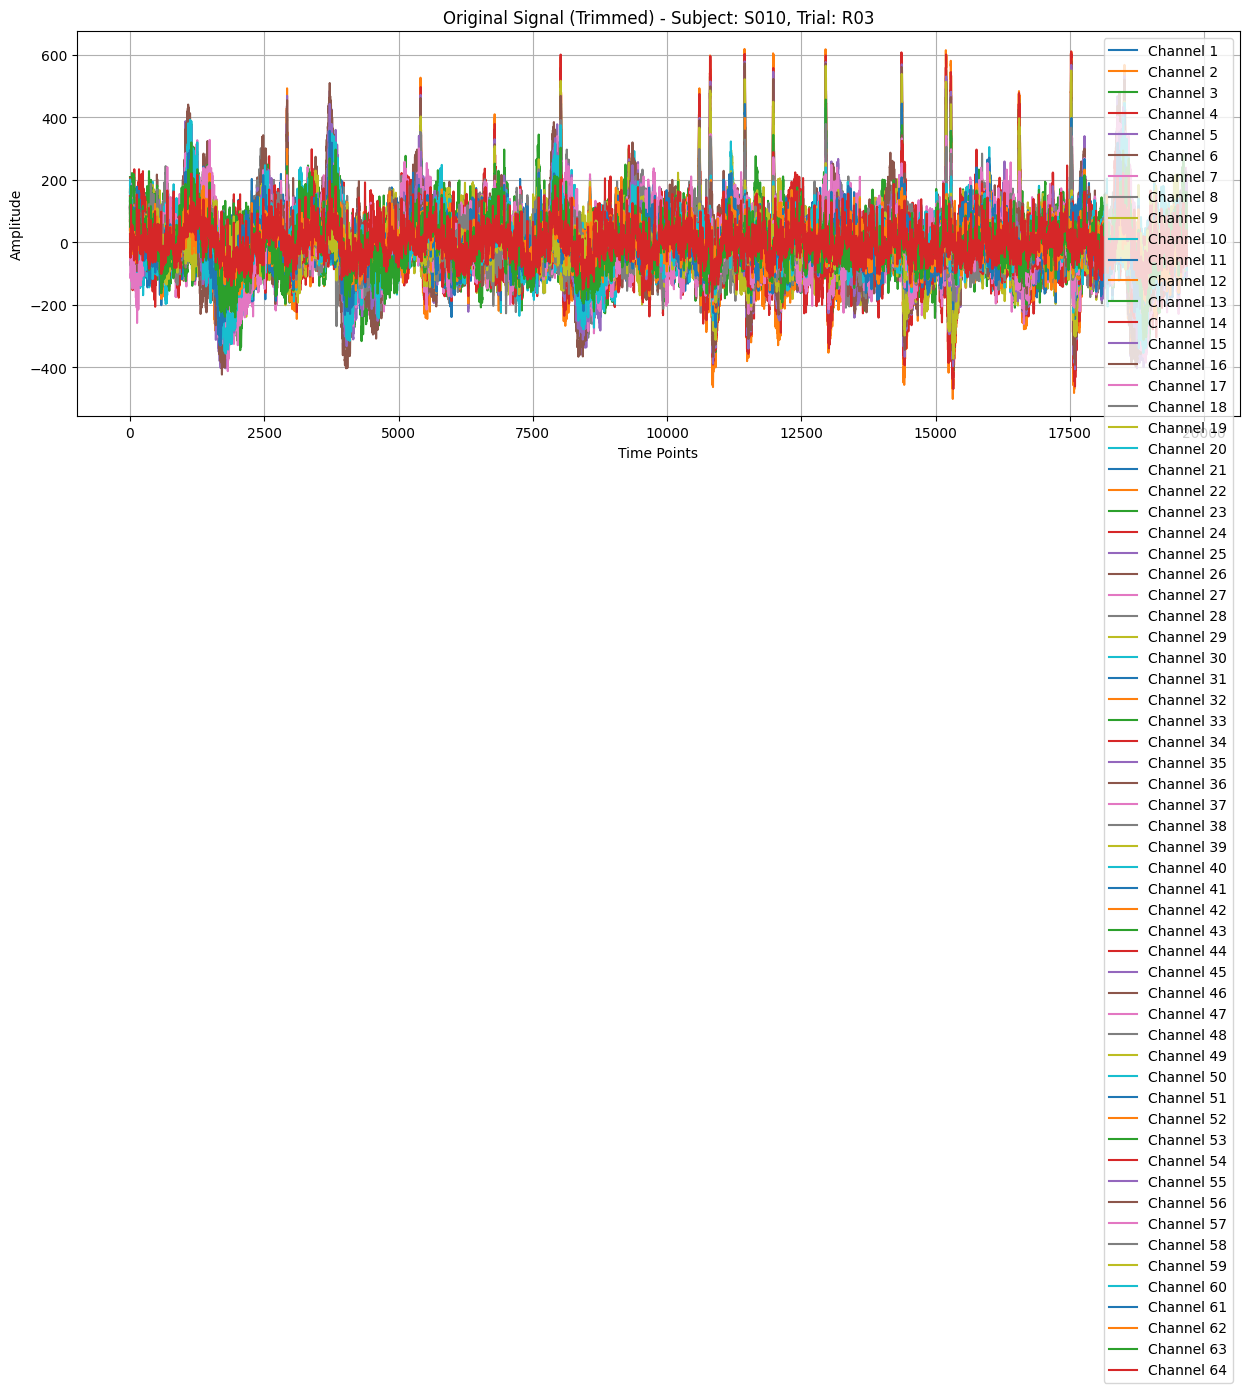

In [12]:
import matplotlib.pyplot as plt

# 隨機選擇一個 subject 和一個試驗的數據進行可視化
subject_to_plot = 'S010'  # 修改為你想要查看的 Subject
trial_to_plot = 'R03'  # 修改為你想要查看的試驗

file_path = f'/Users/Jer_ry/Library/Mobile Documents/com~apple~CloudDocs/大四上/類神經網路/期末報告/physioNet/{subject_to_plot}/{subject_to_plot}{trial_to_plot}.edf'
edf_reader = pyedflib.EdfReader(file_path)
n_signals = edf_reader.signals_in_file

# 截取數據到最短長度
signals = np.zeros((n_signals, min_trial_length))
for ch in range(n_signals):
    signals[ch, :] = edf_reader.readSignal(ch)[:min_trial_length]
edf_reader.close()

# 可視化
plt.figure(figsize=(15, 5))
for ch in range(n_signals):
    plt.plot(signals[ch, :], label=f"Channel {ch+1}")
plt.title(f"Original Signal (Trimmed) - Subject: {subject_to_plot}, Trial: {trial_to_plot}")
plt.xlabel("Time Points")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()


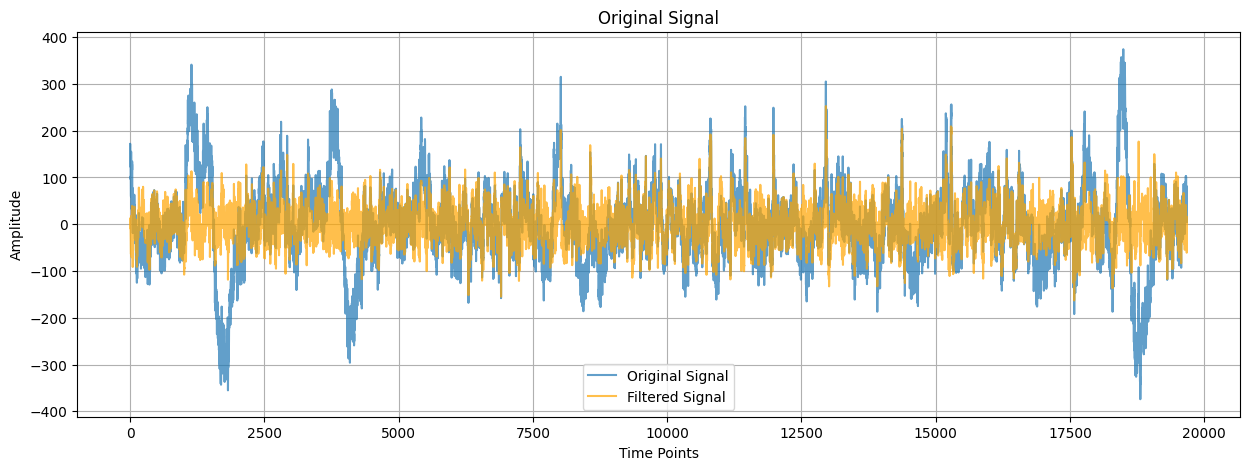

In [14]:
# 對信號進行濾波
filtered_signal = bandpass_filter(signals, lowcut, highcut, fs=fs, order=4)

# 可視化濾波前後的對比
plt.figure(figsize=(15, 5))
plt.plot(signals[0, :], label="Original Signal", alpha=0.7)
plt.plot(filtered_signal[0, :], label="Filtered Signal", alpha=0.7, color='orange')
plt.title("Original Signal")
plt.xlabel("Time Points")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()



### 訊號分佈直方圖
* 圖示內容：展示所有信號數據的值分佈情況，以直方圖形式顯示。
* 目的：
  * 檢查數據值範圍，是否存在異常的極值（例如高 noise）。
  * 了解訊號值是否呈常態分佈或其他特定模式。
* 解讀方式：
  * 集中程度：數據是否集中在特定區間？例如，腦波信號通常有較小的振幅範圍，過大的範圍可能提示噪聲。
  * 極值檢查：直方圖中是否有異常的極值（長尾分佈或孤立峰值），這些可能是伪影或測量誤差。
  * 分佈形態：是否接近正態分佈？大多數信號的分佈應該對稱或略有偏態。
* 下一步：
  * 如果數據分佈異常，需進一步濾波處理或截除極端值。
* 應用場景：在正規化或特徵提取之前檢查數據分佈是否需要特殊處理（例如去除極值或平滑）。

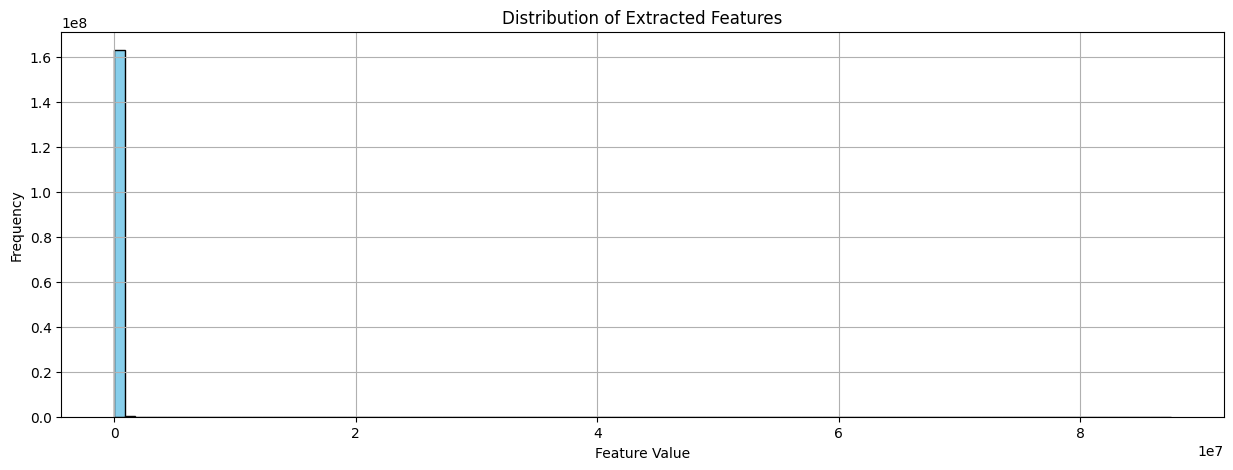

In [16]:
# 假設特徵提取結果存放在 all_data
plt.figure(figsize=(15, 5))
plt.hist(all_data.flatten(), bins=100, color='skyblue', edgecolor='black')
plt.title("Distribution of Extracted Features")
plt.xlabel("Feature Value")
plt.ylabel("Frequency")
plt.grid()
plt.show()


### 可視化 label 分佈
- 圖示內容：展示數據標籤的分佈情況，檢查每個標籤的數據量。
- 目的：
  - 確保標籤分佈平衡，避免某些標籤的數據量過多或過少導致偏差。
  - 幫助理解數據集的整體結構。
- 應用場景：在模型訓練前確認類別不平衡問題，必要時進行數據重採樣。


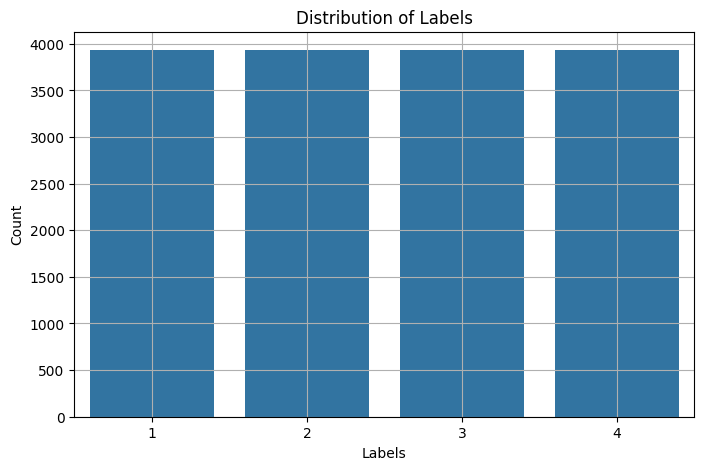

In [61]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(x=all_labels)
plt.title("Distribution of Labels")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.grid()
plt.show()


### 比較 Normalized 後的訊號
* 圖示內容：對比原始信號與正規化後的信號數據。
* 目的：
  * 驗證正規化過程是否成功，數據值範圍是否被縮放到目標範圍（如 [0, 1]）。
  * 確保正規化不會改變信號的主要特徵（如振幅相對大小和波形）。
- 解讀方式：
  - 值範圍縮放：確認信號值是否成功縮放到 [0, 1] 或 [-1, 1] 範圍內。
  - 相對特徵保留：正規化後，信號的形態應該與原始信號一致。例如，波形的峰值和谷值應仍在同一位置。
  - 縮放異常：檢查是否有數據被壓縮過度或偏移（如所有值都接近 0）。
  - 下一步：
    - 如果正規化後信號的形態發生明顯改變，需檢查正規化方法或考慮其他預處理技術（如標準化）。
* 應用場景：檢查數據預處理的質量，避免因正規化失誤導致信息丟失。

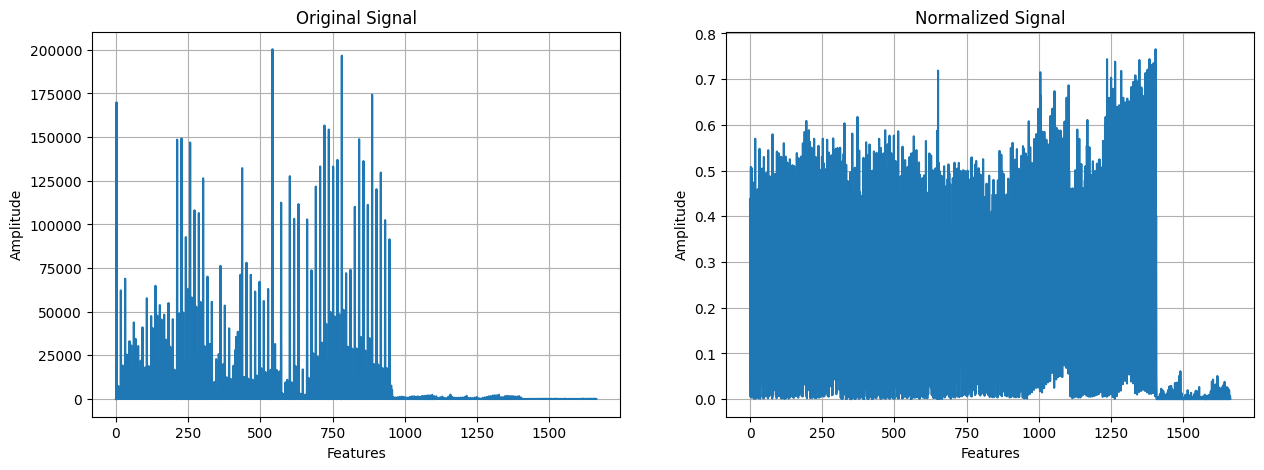

In [17]:
# 可視化正規化前後的信號
plt.figure(figsize=(15, 5))

# 原始信號
plt.subplot(1, 2, 1)
plt.plot(X_train[0])
plt.title("Original Signal")
plt.xlabel("Features")
plt.ylabel("Amplitude")
plt.grid()

# 正規化後信號
plt.subplot(1, 2, 2)
plt.plot(X_train_norm1[0])
plt.title("Normalized Signal")
plt.xlabel("Features")
plt.ylabel("Amplitude")
plt.grid()


###  PCA 或 t-SNE 降維視覺化
#### PCA
* 圖示內容：使用 PCA 將高維數據降維到 2D，並根據標籤進行著色。
* 目的：
  * 查看不同類別的數據分佈情況，檢查是否存在明顯的分類邊界。
  * 確保數據中包含一定的區分性，支持後續分類任務。
* 應用場景：檢查特徵提取的效果，以及數據類別是否可分。
* 解讀方式：
  * 如果同一類別數據形成緊湊的簇，則說明數據具有良好的分類性。
  * 類別之間的分佈是否有明顯邊界，反映特徵提取的效果。
  * 如果類別分佈混亂，可能意味著需要更強的特徵工程。
#### t-SNE
* 圖示內容：使用 t-SNE 將高維數據降維到 2D，並根據標籤進行著色。
* 目的：
  * 更適合處理非線性數據的降維，視覺化數據的潛在結構。
  * 幫助理解不同類別之間的分佈關係。
* 應用場景：進一步檢查數據是否存在內在結構性差異，用於評估分類難度。
  * t-SNE 更適合非線性分佈，能夠更清晰地揭示內部結構。
  * 如果同類數據形成孤立的團簇，則模型可以輕鬆區分類別。
  * 如果不同類別之間的距離模糊或重疊，分類難度可能較高。
    * 根據降維視覺化結果調整特徵提取方法或增加更具鑑別力的特徵。

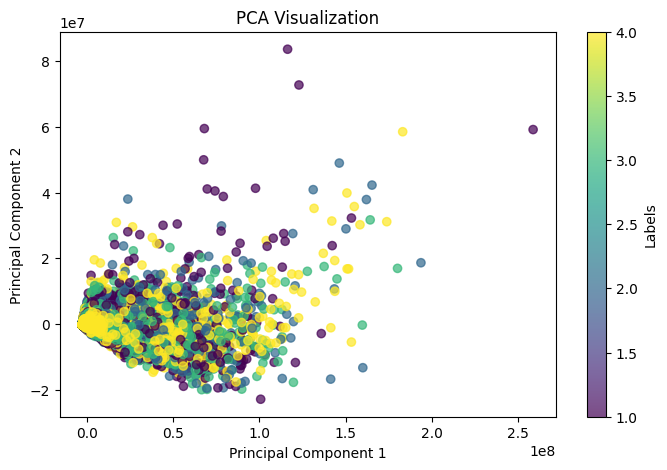

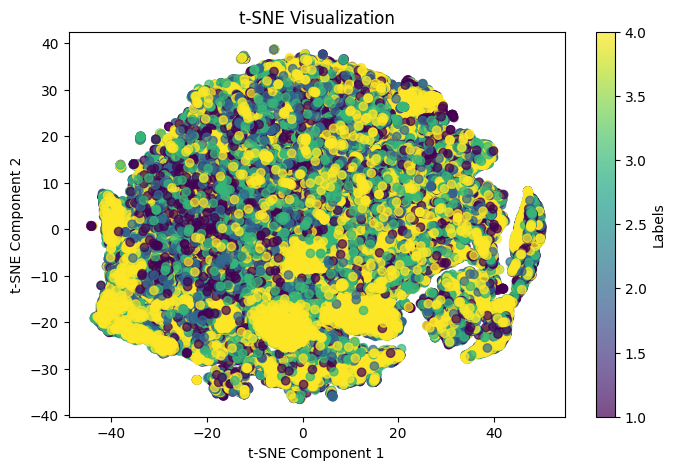

In [18]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# PCA 可視化
pca = PCA(n_components=2)
X_pca = pca.fit_transform(all_data)

plt.figure(figsize=(8, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=all_labels, cmap='viridis', alpha=0.7)
plt.title("PCA Visualization")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Labels")
plt.show()

# t-SNE 可視化
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(all_data)

plt.figure(figsize=(8, 5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=all_labels, cmap='viridis', alpha=0.7)
plt.title("t-SNE Visualization")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(label="Labels")
plt.show()


In [71]:

X_train, X_test, y_train, y_test = train_test_split(all_data, all_labels, test_size=0.2, random_state=42, stratify=all_labels)

# CPN

In [32]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim

# 假設此時你的 all_data, all_labels 已經定義完成
# all_data: shape (N, features)
# all_labels: shape (N, ), 標籤為整數類別(如 1,2,3,4)

# 先假設標籤從 1 開始，如果標籤不是從 0 開始，建議轉換一下
all_labels = all_labels - 1  # 若原標籤為1,2,3,4，轉成0,1,2,3

X_train, X_test, y_train, y_test = train_test_split(all_data, all_labels, test_size=0.2, random_state=42, stratify=all_labels)

class CPN:
    def __init__(self, input_dim, som_size=(10,10), num_classes=4, som_lr=0.05, som_epochs=20000):
        self.input_dim = input_dim
        self.som_size = som_size
        self.num_classes = num_classes
        self.som_lr = som_lr
        self.som_epochs = som_epochs
        
        # 初始化 SOM 權重，shape: (som_x, som_y, input_dim)
        self.som_weights = np.random.randn(som_size[0], som_size[1], input_dim)
        
        # 初始化 Grossberg layer 權重
        self.grossberg_weights = np.random.randn(som_size[0]*som_size[1], num_classes)
        
    def find_bmu(self, x):
        diff = self.som_weights - x
        dist = np.sum(diff**2, axis=2)
        bmu_idx = np.unravel_index(np.argmin(dist), self.som_size)
        return bmu_idx
    
    def train_som(self, X):
        """
        使用動態鄰域與動態學習率來訓練 SOM。
        假設:
        - self.som_size: (som_x, som_y)
        - self.som_weights: shape (som_x, som_y, input_dim)
        - self.som_epochs: 總訓練迭代次數
        - self.som_lr: 初始學習率
        """
        som_x, som_y = self.som_size
        
        # 設定初始鄰域半徑 (通常取網格較長邊的一半)
        initial_radius = max(som_x, som_y) / 2
        initial_lr = self.som_lr
        
        for epoch in range(self.som_epochs):
            # 隨機選一筆資料
            idx = np.random.randint(0, X.shape[0])
            x = X[idx]
            
            # 找到 BMU
            diff = self.som_weights - x
            dist = np.sum(diff**2, axis=2)
            bmu_idx = np.unravel_index(np.argmin(dist), self.som_size)
            
            # 動態調整學習率與鄰域半徑
            # 這裡以指數衰減為例
            decay = np.exp(-epoch / (self.som_epochs / 2))
            lr = initial_lr * decay
            radius = initial_radius * decay
            
            # 計算各神經元與 BMU 的格點距離 (拓撲距離)
            # SOM 網格為 2D，可以使用歐式距離
            bmu_x, bmu_y = bmu_idx
            x_coords, y_coords = np.arange(som_x), np.arange(som_y)
            X_mesh, Y_mesh = np.meshgrid(x_coords, y_coords)
            # 計算各點到 BMU 的距離
            dist_to_bmu = (X_mesh - bmu_x)**2 + (Y_mesh - bmu_y)**2
            # 使用高斯鄰域函數
            neighborhood = np.exp(-dist_to_bmu / (2*(radius**2))).reshape(som_x, som_y, 1)
            
            # 更新 SOM 權重
            # 權重更新公式： W(t+1) = W(t) + lr * neighborhood * (x - W(t))
            # (x - W) shape 要廣播一致
            update = lr * neighborhood * (x - self.som_weights)
            self.som_weights += update
    
    def encode_input_with_som(self, X):
        # 將資料經 SOM 映射為 One-hot 編碼
        som_x, som_y = self.som_size
        encoded = []
        for x in X:
            bmu_idx = self.find_bmu(x)
            bmu_flat = bmu_idx[0]*som_y + bmu_idx[1]
            one_hot = np.zeros(som_x*som_y)
            one_hot[bmu_flat] = 1.0
            encoded.append(one_hot)
        return np.array(encoded)
    
    def train_grossberg(self, X_encoded, Y, lr=0.01, epochs=500):
        # 將 Y 轉成 one-hot
        Y_one_hot = np.zeros((Y.shape[0], self.num_classes))
        for i, label in enumerate(Y):
            Y_one_hot[i, label] = 1
        
        for ep in range(epochs):
            net = X_encoded.dot(self.grossberg_weights)
            diff = Y_one_hot - net
            grad = -X_encoded.T.dot(diff) / X_encoded.shape[0]
            self.grossberg_weights -= lr * grad
    
    def predict(self, X):
        encoded = self.encode_input_with_som(X)
        net = encoded.dot(self.grossberg_weights)
        preds = np.argmax(net, axis=1)
        return preds

# 已有的程式碼 (假設 all_data, all_labels 已經存在，並已分割成 X_train, X_test, y_train, y_test)
input_dim = X_train.shape[1]  # Features數量
num_classes = len(np.unique(y_train)) # 類別數量

cpn = CPN(input_dim=input_dim, som_size=(12,12), num_classes=num_classes, som_lr=0.05, som_epochs=20000)

# 訓練 SOM (無監督)
print("Training SOM...")
cpn.train_som(X_train)

# 使用訓練好的 SOM 將資料編碼
X_train_encoded = cpn.encode_input_with_som(X_train)
X_test_encoded = cpn.encode_input_with_som(X_test)

# 不再使用 cpn.train_grossberg，改用 PyTorch 訓練 Grossberg layer
print("Training Grossberg layer with CrossEntropy...")

# 將資料轉為 Tensor
X_train_tensor = torch.tensor(X_train_encoded, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_encoded, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# 定義 Grossberg layer 為一個 Linear model
model = nn.Linear(X_train_encoded.shape[1], num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 3000
batch_size = 64 # batch 的意思是一次訓練多少筆資料後更新權重
N = X_train_tensor.size(0)

for epoch in range(epochs):
    # shuffle data
    perm = torch.randperm(N)
    X_train_shuffled = X_train_tensor[perm]
    y_train_shuffled = y_train_tensor[perm]
    
    for i in range(0, N, batch_size):
        x_batch = X_train_shuffled[i:i+batch_size]
        y_batch = y_train_shuffled[i:i+batch_size]

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
    
    # 可選擇印出訓練過程中的 loss 或 accuracy
    with torch.no_grad():
        train_outputs = model(X_train_tensor)
        train_pred = torch.argmax(train_outputs, dim=1)
        train_acc = (train_pred == y_train_tensor).float().mean().item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Train Acc: {train_acc:.4f}")

# 測試集評估
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_pred = torch.argmax(test_outputs, dim=1)
    acc = (test_pred == y_test_tensor).float().mean().item()

print("Test Accuracy:", acc)



Training SOM...
Training Grossberg layer with CrossEntropy...
Epoch [1/3000], Loss: 1.3969, Train Acc: 0.2679
Epoch [2/3000], Loss: 1.3530, Train Acc: 0.2631
Epoch [3/3000], Loss: 1.3473, Train Acc: 0.2646
Epoch [4/3000], Loss: 1.3655, Train Acc: 0.2651
Epoch [5/3000], Loss: 1.3911, Train Acc: 0.2667
Epoch [6/3000], Loss: 1.3468, Train Acc: 0.2668
Epoch [7/3000], Loss: 1.3744, Train Acc: 0.2617
Epoch [8/3000], Loss: 1.4139, Train Acc: 0.2658
Epoch [9/3000], Loss: 1.3676, Train Acc: 0.2679
Epoch [10/3000], Loss: 1.3686, Train Acc: 0.2657
Epoch [11/3000], Loss: 1.4069, Train Acc: 0.2670
Epoch [12/3000], Loss: 1.4474, Train Acc: 0.2677
Epoch [13/3000], Loss: 1.4036, Train Acc: 0.2677
Epoch [14/3000], Loss: 1.3979, Train Acc: 0.2648
Epoch [15/3000], Loss: 1.4386, Train Acc: 0.2617
Epoch [16/3000], Loss: 1.3667, Train Acc: 0.2644
Epoch [17/3000], Loss: 1.4206, Train Acc: 0.2631
Epoch [18/3000], Loss: 1.3706, Train Acc: 0.2646
Epoch [19/3000], Loss: 1.3378, Train Acc: 0.2637
Epoch [20/3000],

In [33]:
import torch
import torch.nn as nn
import torch.utils.data as Data
from sklearn.neighbors import KNeighborsClassifier


# 將數據轉換為 PyTorch 張量
X_train_norm1 = torch.tensor(X_train_norm1).float()
y_train = torch.tensor(y_train.flatten()).long()
X_test_norm1 = torch.tensor(X_test_norm1).float()
y_test = torch.tensor(y_test.flatten()).long()

# 超參數
LR = 0.005  # learning rate
EPOCH = 100
BATCH_size = 64

# 設置 data loader
train_data = Data.TensorDataset(X_train_norm1, y_train)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_size, shuffle=True)

# 定義 AutoEncoder
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(all_data.shape[1], 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 4),
        )
        self.decoder = nn.Sequential(
            nn.Linear(4, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, all_data.shape[1]),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

autoencoder = AutoEncoder()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
loss_func = nn.MSELoss()

# 訓練 AutoEncoder
knn = KNeighborsClassifier(n_neighbors=3)
best_acc = []

for epoch in range(EPOCH):
    autoencoder.train()
    for step, (b_x, b_y) in enumerate(train_loader):
        b_x_flat = b_x.view(b_x.size(0), -1)  # 展平输入
        encoded, decoded = autoencoder(b_x_flat)
        loss = loss_func(decoded, b_x_flat)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 100 == 0:
            print('Epoch: ', epoch, '| Step:', step, '| train loss: %.4f' % loss.item())

    # 評估 AutoEncoder
    autoencoder.eval()
    with torch.no_grad():
        X_train_flat = X_train_norm1.view(X_train_norm1.size(0), -1)
        X_test_flat = X_test_norm1.view(X_test_norm1.size(0), -1)

        encoded_train, _ = autoencoder(X_train_flat)
        encoded_test, _ = autoencoder(X_test_flat)
        knn.fit(encoded_train.numpy(), y_train.numpy())
        acc = knn.score(encoded_test.numpy(), y_test.numpy())
        best_acc.append(acc)
        print('Epoch: ', epoch, '| Test Accuracy: %.4f' % acc)

print('Best Test Accuracy:', max(best_acc))


Epoch:  0 | Step: 0 | train loss: 0.1495
Epoch:  0 | Step: 100 | train loss: 0.0013
Epoch:  0 | Step: 200 | train loss: 0.0012
Epoch:  0 | Step: 300 | train loss: 0.0012
Epoch:  0 | Step: 400 | train loss: 0.0009
Epoch:  0 | Step: 500 | train loss: 0.0010
Epoch:  0 | Step: 600 | train loss: 0.0009
Epoch:  0 | Step: 700 | train loss: 0.0008
Epoch:  0 | Step: 800 | train loss: 0.0010
Epoch:  0 | Step: 900 | train loss: 0.0011
Epoch:  0 | Step: 1000 | train loss: 0.0011
Epoch:  0 | Step: 1100 | train loss: 0.0008
Epoch:  0 | Step: 1200 | train loss: 0.0008
Epoch:  0 | Step: 1300 | train loss: 0.0010
Epoch:  0 | Step: 1400 | train loss: 0.0008
Epoch:  0 | Step: 1500 | train loss: 0.0008
Epoch:  0 | Step: 1600 | train loss: 0.0008
Epoch:  0 | Step: 1700 | train loss: 0.0008
Epoch:  0 | Step: 1800 | train loss: 0.0007
Epoch:  0 | Step: 1900 | train loss: 0.0008
Epoch:  0 | Step: 2000 | train loss: 0.0010
Epoch:  0 | Step: 2100 | train loss: 0.0009
Epoch:  0 | Step: 2200 | train loss: 0.0006


## AE + KNN (2 vs 4)

In [34]:
import torch
import torch.nn as nn
import torch.utils.data as Data
from sklearn.neighbors import KNeighborsClassifier


# 將數據轉換為 PyTorch 張量
X_train_norm1 = torch.tensor(X_train_norm1).float()
y_train = torch.tensor(y_train.flatten()).long()
X_test_norm1 = torch.tensor(X_test_norm1).float()
y_test = torch.tensor(y_test.flatten()).long()

# 超參數
LR = 0.005  # learning rate
EPOCH = 100
BATCH_size = 64

# 設置 data loader
train_data = Data.TensorDataset(X_train_norm1, y_train)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_size, shuffle=True)

# 定義 AutoEncoder
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(all_data.shape[1], 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 4),
        )
        self.decoder = nn.Sequential(
            nn.Linear(4, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, all_data.shape[1]),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

autoencoder = AutoEncoder()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
loss_func = nn.MSELoss()

# 訓練 AutoEncoder
knn = KNeighborsClassifier(n_neighbors=3)
best_acc = []

for epoch in range(EPOCH):
    autoencoder.train()
    for step, (b_x, b_y) in enumerate(train_loader):
        b_x_flat = b_x.view(b_x.size(0), -1)  # 展平输入
        encoded, decoded = autoencoder(b_x_flat)
        loss = loss_func(decoded, b_x_flat)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 100 == 0:
            print('Epoch: ', epoch, '| Step:', step, '| train loss: %.4f' % loss.item())

    # 評估 AutoEncoder
    autoencoder.eval()
    with torch.no_grad():
        X_train_flat = X_train_norm1.view(X_train_norm1.size(0), -1)
        X_test_flat = X_test_norm1.view(X_test_norm1.size(0), -1)

        encoded_train, _ = autoencoder(X_train_flat)
        encoded_test, _ = autoencoder(X_test_flat)
        knn.fit(encoded_train.numpy(), y_train.numpy())
        acc = knn.score(encoded_test.numpy(), y_test.numpy())
        best_acc.append(acc)
        print('Epoch: ', epoch, '| Test Accuracy: %.4f' % acc)

print('Best Test Accuracy:', max(best_acc))


/var/folders/hy/wjct6sqs2wn5jw6zc8t5fh5h0000gn/T/ipykernel_13236/747508117.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_norm1 = torch.tensor(X_train_norm1).float()
/var/folders/hy/wjct6sqs2wn5jw6zc8t5fh5h0000gn/T/ipykernel_13236/747508117.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train.flatten()).long()
/var/folders/hy/wjct6sqs2wn5jw6zc8t5fh5h0000gn/T/ipykernel_13236/747508117.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_norm1 = torch.tensor(X_test_norm1).float()
/var/folder

Epoch:  0 | Step: 0 | train loss: 0.1506
Epoch:  0 | Step: 100 | train loss: 0.0014
Epoch:  0 | Step: 200 | train loss: 0.0010
Epoch:  0 | Step: 300 | train loss: 0.0010
Epoch:  0 | Step: 400 | train loss: 0.0011
Epoch:  0 | Step: 500 | train loss: 0.0009
Epoch:  0 | Step: 600 | train loss: 0.0010
Epoch:  0 | Step: 700 | train loss: 0.0007
Epoch:  0 | Step: 800 | train loss: 0.0012
Epoch:  0 | Step: 900 | train loss: 0.0008
Epoch:  0 | Step: 1000 | train loss: 0.0009
Epoch:  0 | Step: 1100 | train loss: 0.0010
Epoch:  0 | Step: 1200 | train loss: 0.0009
Epoch:  0 | Step: 1300 | train loss: 0.0007
Epoch:  0 | Step: 1400 | train loss: 0.0007
Epoch:  0 | Step: 1500 | train loss: 0.0008
Epoch:  0 | Step: 1600 | train loss: 0.0007
Epoch:  0 | Step: 1700 | train loss: 0.0008
Epoch:  0 | Step: 1800 | train loss: 0.0007
Epoch:  0 | Step: 1900 | train loss: 0.0007
Epoch:  0 | Step: 2000 | train loss: 0.0008
Epoch:  0 | Step: 2100 | train loss: 0.0008
Epoch:  0 | Step: 2200 | train loss: 0.0007


# CNN

In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

# CNN 模型構建
def build_cnn(input_shape, num_classes):
    model = Sequential()
    
    # 第一層卷積 + 批正規化 + 池化
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    
    # 第二層卷積 + 批正規化 + 池化
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    
    # 展平特徵
    model.add(Flatten())
    
    # 全連接層 + Dropout
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    
    # 輸出層（多類別分類）
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

segment_length = segment
no_feature = 64
# 模型參數
input_shape = (segment_length, no_feature)  # (16, 64)
num_classes = len(np.unique(y_train))  # 類別數目

# 建立 CNN 模型
cnn_model = build_cnn(input_shape, num_classes)

# 編譯模型
cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 查看模型結構
cnn_model.summary()

# 訓練模型
history = cnn_model.fit(
    X_train_norm1, y_train, 
    epochs=20, 
    batch_size=64, 
    validation_data=(X_test_norm1, y_test)
)


/Users/Jer_ry/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 32)            6176      
                                                                 
 batch_normalization (Batch  (None, 30, 32)            128       
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 15, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 13, 64)            6208      
                                                                 
 batch_normalization_1 (Bat  (None, 13, 64)            256       
 chNormalization)                                                
                                                        

TypeError: Cannot convert the argument `type_value`: torch.float32 to a TensorFlow DType.

In [ ]:
# 訓練和驗證的準確率曲線
plt.figure(figsize=(12, 5))

# 準確率
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 損失
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()